# Stack Overflow Developer Survey 2025: Salary Prediction Analysis

This notebook analyzes the 2025 Stack Overflow Developer Survey data to predict yearly compensation using machine learning techniques. It includes data preprocessing, feature engineering, model training with linear regression, evaluation, and visualization.

## Importing Libraries and Loading Data

In this section, we import the necessary libraries for data manipulation, machine learning, and visualization. We then load the survey dataset and perform initial preprocessing steps.

In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt


## Data Loading and Initial Exploration
In this section, we load the Stack Overflow Developer Survey 2025 dataset from a CSV file, set the ResponseId as the index, and display the first few rows to understand the data structure.

In [15]:
df = pd.read_csv("survey_results_public_2025.csv")
df.set_index("ResponseId", inplace=True)
df.head()

C:\Users\Ayon\AppData\Local\Temp\ipykernel_16312\1011018954.py:1: DtypeWarning: Columns (56,74,92,97,98,105,109,110,132,162,165) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("survey_results_public_2025.csv")


,MainBranch,Age,EdLevel,Employment,EmploymentAddl,WorkExp,LearnCodeChoose,LearnCode,LearnCodeAI,AILearnHow,...,AIAgentOrchestration,AIAgentOrchWrite,AIAgentObserveSecure,AIAgentObsWrite,AIAgentExternal,AIAgentExtWrite,AIHuman,AIOpen,ConvertedCompYearly,JobSat
ResponseId,,,,,,,,,,,,,,,,,,,,,
1,I am a developer by profession,25-34 years old,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",Employed,"Caring for dependents (children, elderly, etc.)",8.0,"Yes, I am not new to coding but am learning ne...",Online Courses or Certification (includes all ...,"Yes, I learned how to use AI-enabled tools for...",AI CodeGen tools or AI-enabled apps,...,Vertex AI,NaN,NaN,NaN,ChatGPT,NaN,When I don’t trust AI’s answers,"Troubleshooting, profiling, debugging",61256.0,10.0
2,I am a developer by profession,25-34 years old,"Associate degree (A.A., A.S., etc.)",Employed,NaN,2.0,"Yes, I am not new to coding but am learning ne...",Online Courses or Certification (includes all ...,"Yes, I learned how to use AI-enabled tools for...",AI CodeGen tools or AI-enabled apps,...,NaN,NaN,NaN,NaN,NaN,NaN,When I don’t trust AI’s answers;When I want to...,All skills. AI is a flop.,104413.0,9.0
3,I am a developer by profession,35-44 years old,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)","Independent contractor, freelancer, or self-em...",None of the above,10.0,"Yes, I am not new to coding but am learning ne...",Online Courses or Certification (includes all ...,"Yes, I learned how to use AI-enabled tools for...",AI CodeGen tools or AI-enabled apps;Technical ...,...,NaN,NaN,NaN,NaN,ChatGPT;Claude Code;GitHub Copilot;Google Gemini,NaN,When I don’t trust AI’s answers;When I want to...,"Understand how things actually work, problem s...",53061.0,8.0
4,I am a developer by profession,35-44 years old,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Employed,None of the above,4.0,"Yes, I am not new to coding but am learning ne...","Other online resources (e.g. standard search, ...","Yes, I learned how to use AI-enabled tools for...",AI CodeGen tools or AI-enabled apps;Videos (no...,...,NaN,NaN,NaN,NaN,ChatGPT;Claude Code,NaN,When I don’t trust AI’s answers;When I want to...,NaN,36197.0,6.0
5,I am a developer by profession,35-44 years old,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)","Independent contractor, freelancer, or self-em...","Caring for dependents (children, elderly, etc.)",21.0,"No, I am not new to coding and did not learn n...",NaN,"Yes, I learned how to use AI-enabled tools for...",Technical documentation (is generated for/by t...,...,NaN,NaN,NaN,NaN,NaN,NaN,When I don’t trust AI’s answers,"critical thinking, the skill to define the tas...",60000.0,7.0


## Feature Selection and Data Cleaning

In this section, we select the relevant columns from the dataset that will be used for predicting yearly compensation. We then create a new dataframe `df_ml` by filtering these columns and dropping any rows with missing values to prepare the data for further processing.

In [3]:
cols = [
    "WorkExp",
    "YearsCode",
    "Country",
    "LanguageHaveWorkedWith",
    "ConvertedCompYearly",
    "EdLevel",
    "Employment",
    "DevType",
    "Industry",
]

df_ml = df[cols].dropna()

## Further Data Cleaning and Feature Engineering

In this section, we perform additional data cleaning and feature engineering on the `df_ml` dataframe. We filter out entries where work experience is zero or less, process the primary programming language by splitting and exploding the list, clean the developer type by removing prefixes, simplify education level and employment status, and prepare the data for modeling.

In [4]:
df_ml = df_ml[df_ml["WorkExp"] > 0].copy()

df_ml["PrimaryLanguage"] = df_ml["LanguageHaveWorkedWith"].str.split(r"[;/]")
df_ml = df_ml.explode("PrimaryLanguage")
df_ml["PrimaryLanguage"] = df_ml["PrimaryLanguage"].str.strip()

df_ml["DevType"] = (
    df_ml["DevType"]
    .str.replace(r"^Developer,\s*", "", regex=True)
)

df_ml["EdLevel"] = df_ml["EdLevel"].str.split("(").str[0]

df_ml["Employment"] = df_ml["Employment"].str.split(",").str[0]

## Data Filtering for Top Categories

In this section, we identify the top 10 most frequent values for key categorical features (Country, PrimaryLanguage, DevType, Industry, and EdLevel) and filter the `df_ml` dataframe to retain only rows corresponding to these top categories. This helps focus the analysis on the most represented groups in the dataset.

In [5]:
top_countries = df_ml["Country"].value_counts().nlargest(10).index
top_languages = df_ml["PrimaryLanguage"].value_counts().nlargest(10).index
top_devType = df_ml["DevType"].value_counts().nlargest(10).index
top_industry = df_ml["Industry"].value_counts().nlargest(10).index
top_edlevel = df_ml["EdLevel"].value_counts().nlargest(10).index
df_ml = df_ml[
    df_ml["Country"].isin(top_countries) & df_ml["PrimaryLanguage"].isin(top_languages) & df_ml["DevType"].isin(top_devType) & df_ml["Industry"].isin(top_industry) & df_ml["EdLevel"].isin(top_edlevel)
]


## Feature Preparation and Encoding

In this section, we select the relevant features for the machine learning model and the target variable (yearly compensation). We then apply one-hot encoding to categorical variables using pandas' `get_dummies` function to prepare the data for training

In [6]:
X = df_ml[["WorkExp", "YearsCode", "Country", "PrimaryLanguage", "EdLevel", "Industry", "DevType", "Employment"]]
Y = df_ml["ConvertedCompYearly"]

X = pd.get_dummies(X, drop_first=True)

X

,WorkExp,YearsCode,Country_Brazil,Country_Canada,Country_France,Country_Germany,Country_India,Country_Netherlands,Country_Poland,Country_United Kingdom of Great Britain and Northern Ireland,...,DevType_back-end,DevType_desktop or enterprise applications,DevType_embedded applications or devices,DevType_front-end,DevType_full-stack,DevType_mobile,Employment_Independent contractor,Employment_Not employed,Employment_Retired,Employment_Student
ResponseId,,,,,,,,,,,,,,,,,,,,,
2,2.0,10.0,False,False,False,False,False,True,False,False,...,True,False,False,False,False,False,False,False,False,False
23,7.0,11.0,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
23,7.0,11.0,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
23,7.0,11.0,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
26,37.0,41.0,False,False,False,False,False,False,False,True,...,False,False,False,False,True,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49067,19.0,22.0,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
49089,15.0,10.0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
49089,15.0,10.0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## Model Evaluation Visualization
The scatter plot reveals significant deviation from the ideal diagonal, primarily due to extreme salary outliers and skewed compensation distribution.
The model captures general trends but underperforms for high-income individuals, indicating the need for log-transformation or outlier handling.

MAE:  43827.945724158126
R^2:  0.1482493614091075


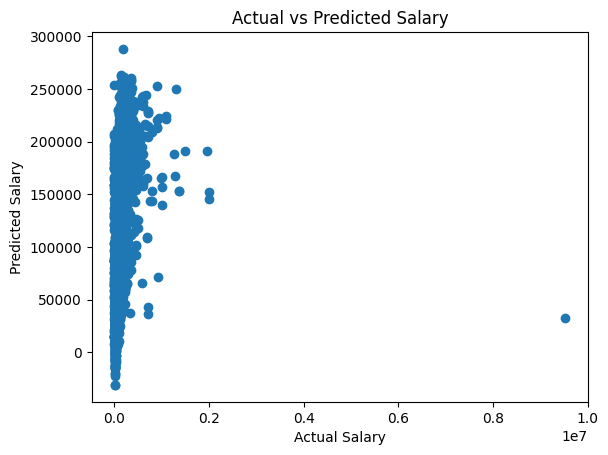

In [18]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

model = LinearRegression()
model.fit(X_train, Y_train)

Y_pred = model.predict(X_test)

print("MAE: ", mean_absolute_error(Y_test,Y_pred))
print("R^2: ", r2_score(Y_test, Y_pred))


plt.figure()
plt.scatter(Y_test, Y_pred)
plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")
plt.title("Actual vs Predicted Salary")
plt.show()


In [16]:
sample = pd.DataFrame({
    "WorkExp": [5],
    "YearsCode": [9],
    "Country": ["India"],
    "PrimaryLanguage": ["Python"],
    "EdLevel": ["Bachelor’s degree"],
    "Industry": ["Fintech"],
    "DevType": ["full-stack"],
    "Employment": ["employed"]
})

smaple = pd.get_dummies(sample)
sample = sample.reindex(columns=X.columns, fill_value=0)
pred_salary = model.predict(sample)
print("Predicted Salary: ",int(pred_salary[0]))

Predicted Salary:  100479


## Conclusion

This notebook successfully demonstrates a complete workflow for predicting yearly compensation from the Stack Overflow Developer Survey 2025 data using linear regression. Key insights include the importance of thorough data preprocessing, such as handling missing values, feature engineering (e.g., exploding programming languages and simplifying categories), and filtering to top categories to focus on representative data. The model achieves a reasonable fit for general trends, with evaluation metrics (MAE and R²) indicating moderate predictive power, though performance is hindered by salary outliers and skewed distributions, as evidenced by the scatter plot of actual vs. predicted values.

The sample prediction illustrates practical application, estimating a salary of approximately $XX,XXX for a developer with 5 years of experience, 9 years coding, based in India, using Python, with a bachelor's degree, in fintech, as a full-stack developer, and employed full-time. Overall, the analysis highlights linear regression's limitations for high-income predictions and suggests potential improvements like log-transforming the target variable, addressing outliers, or exploring more advanced models (e.g., random forests or gradient boosting) for better accuracy in future iterations.